 **Facial Emotion Detection with TensorFlow**

This is a broad sampling of several TensorFlow models. It ranges from a simple NN and CNN, to pretrained models, and then more complex CNNs. Some models have many iterations, in an effort to find the best fit and highest accuracy.


**Problem Definition**

Facial emotion recognition using the TensorFlow framework.
This project involves using machine learning algorithms to detect emotions from facial expressions in real-time. TensorFlow is an open-source machine learning framework that allows developers to build and deploy machine learning models. 


**About the dataset**

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'. 
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>

This dataset is available on Kaggle, and has several more classes to work with. https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

In [1]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf          
import os

# Importing Deep Learning Libraries
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator         # NOTE: Deprecated as of November 2022, code for updated loading is included below. Writte by my colleague, Aldo Tapia.
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [3]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Colab Notebooks/Facial_emotion_images'

# The data is provided as a zip file so we need to extract the files from the zip file
#with zipfile.ZipFile(path, 'r') as zip_ref:
#    zip_ref.extractall()

In [4]:
picture_size = 48
#folder_path = "Facial_emotion_images/"


### **Class Visualization**
 **Happy**

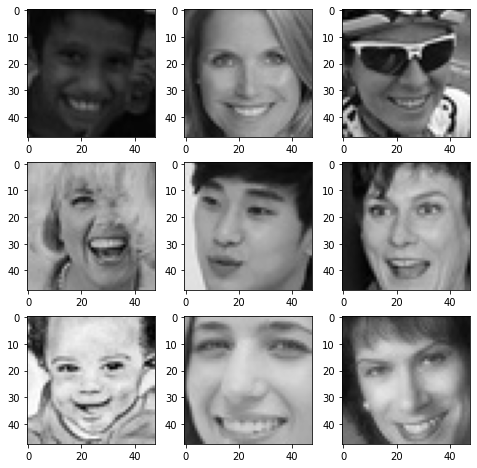

In [ ]:
expression = 'happy'

plt.figure(figsize= (8,8))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img(folder_path + "train/" + expression + "/" +
                  os.listdir(folder_path + "train/" + expression)[i], target_size = (picture_size, picture_size))
    plt.imshow(img)   

plt.show()

**Observations:**
A unique feature for happy is likely the **nasolabial creases**, which are the round "parenthesis" shape around the mouth, that are created and/or accentuated by smiling. While it is possible to say that the angle of the mouth, specifically concave to some degree, would sugest happy, there is a higher chance of confusion with "surprised" faces.

 **Sad**

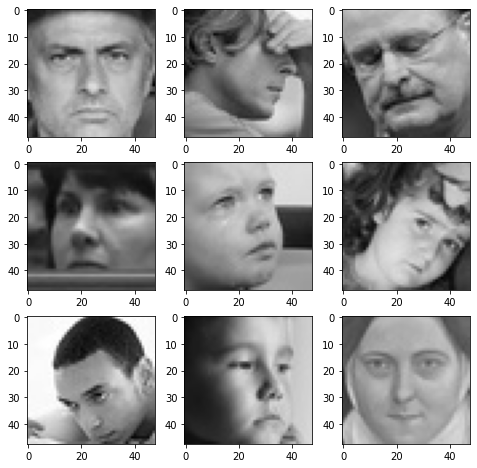

In [ ]:
expression = 'sad'

plt.figure(figsize= (8,8))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img(folder_path + "train/" + expression + "/" +
                  os.listdir(folder_path + "train/" + expression)[i], target_size = (picture_size, picture_size))
    plt.imshow(img)   

plt.show()

**Observations:**
A unique feature for faces that show sadness is the angle of the mouth, specificically straight or convex. Using eyes or eyebrows would increase the possibility of confusion with "surprised" or "happy." 

**Neutral**

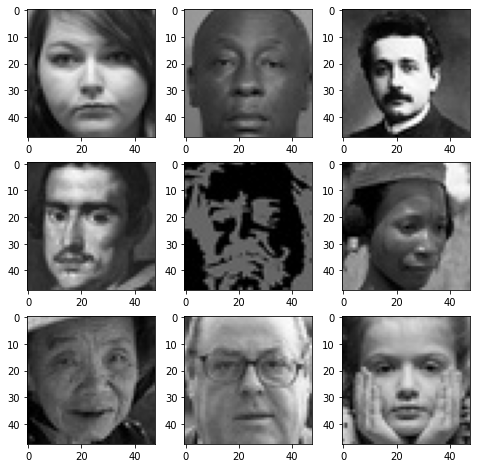

In [ ]:
expression = 'neutral'

plt.figure(figsize= (8,8))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img(folder_path + "train/" + expression + "/" +
                  os.listdir(folder_path + "train/" + expression)[i], target_size = (picture_size, picture_size))
    plt.imshow(img)   

plt.show()

**Observations:** The relative flat line formed by where the lips meet and the flatness of the eyebrows, are specific to the neutral face. There is no exaggeration in either direction, such as sad or happy would have.

**Surprised**

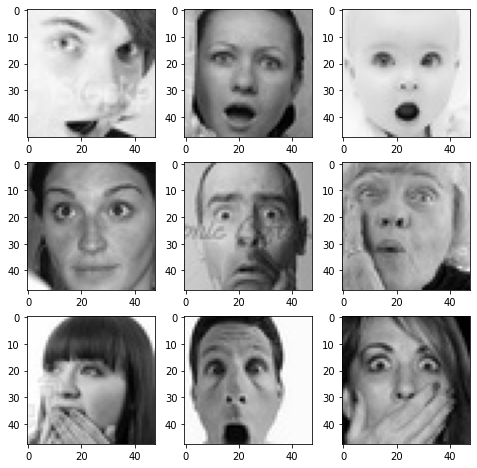

In [ ]:
expression = 'surprise' 

plt.figure(figsize= (8,8))
for i in range(1, 10, 1):
    plt.subplot(3, 3, i)

    img = load_img(folder_path + "train/" + expression + "/" +
                  os.listdir(folder_path + "train/" + expression)[i], target_size = (picture_size, picture_size))
    plt.imshow(img)   

plt.show()

**Observations:** Based on the examples from the "surprised/shocked" class, a mouth that is open and with both convex and concave lip shapes at the same time, is a likely unique feature.  Likely this needs to be paired with arched eyebrows.

**Checking Distribution of Classes**

In [ ]:
# Getting count of images in each folder within our training path
num_happy = len(os.listdir(folder_path + "train/happy"))
print("Number of images in the class 'happy':   ", num_happy)

num_sad = len(os.listdir(folder_path + "train/sad"))
print("Number of images in the class 'sad':   ", num_sad)

num_neutral = len(os.listdir(folder_path + "train/neutral"))
print("Number of images in the class 'neutral':   ", num_neutral)

num_surprise = len(os.listdir(folder_path + "train/surprise"))
print("Number of images in the class 'surprise':   ", num_surprise)

Number of images in the class 'happy':    3976
Number of images in the class 'sad':    3982
Number of images in the class 'neutral':    3978
Number of images in the class 'surprise':    3173


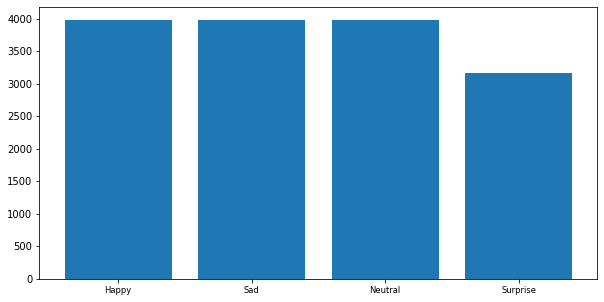

In [ ]:
# Code to plot histogram
plt.figure(figsize = (10, 5))

data = {'Happy': num_happy, 'Sad': num_sad, 'Neutral': num_neutral, 'Surprise' : num_surprise}

df = pd.Series(data)

plt.bar(range(len(df)), df.values, align = 'center')

plt.xticks(range(len(df)), df.index.values, size = 'small')

plt.show()

**Observations:**


*   The average count for 'happy', 'sad', and 'neutral', is 3,978, their totals are within 2-4 +/- of that number. 
*   However, 'surprise' has just over 20% less than the other three classes, with 3,173 total.  
*   This is unequal distribution is considered a class imbalance. A source that explores this more: [A survey on addressing high-class imbalance in big data](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-018-0151-6#Sec12) 
*   There are methods to address this imbalance.
*   I am going to try running the models as they are, then with one or two methods to balance the classes.







**Data Loaders**



In [5]:
batch_size  = 32              #The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'. 
img_size = 48



datagen_train = ImageDataGenerator(horizontal_flip = True,            #train set
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

train_set = datagen_train.flow_from_directory(path + "/train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale',              #below find 'grayscale' then 'rgb' as color modes
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              
                                              shuffle = True)


datagen_validation = ImageDataGenerator(horizontal_flip = True,       #validation set
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

validation_set = datagen_validation.flow_from_directory(path + "/validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale',               #color mode
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              
                                              shuffle = True)


datagen_test = ImageDataGenerator(horizontal_flip = True,           #test set
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

test_set = datagen_test.flow_from_directory(path + "/test",
                                              target_size = (img_size, img_size),
                                              color_mode = 'grayscale',              #color mode               
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                           
                                              shuffle = True)

Found 30218 images belonging to 4 classes.
Found 9954 images belonging to 4 classes.
Found 250 images belonging to 4 classes.


**Base Neural Network**

In [ ]:
def cnn_model_1():
  model = Sequential()

  model.add(Conv2D(filters = 64, kernel_size = (2,2), padding = "same", input_shape = (48, 48, 1), activation = 'relu'))  #grayscale
  model.add(MaxPooling2D(pool_size = (2,2))) #max-pooling layer with a pool size of 2x2
  model.add(Dropout(0.2)) #Add the Dropout layer with the rate equal to 0.2

  model.add(Conv2D(filters = 32, kernel_size = (2,2), padding = "same", activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2))) #max-pooling layer with a pool size of 2x2
  model.add(Dropout(0.2)) #Add the Dropout layer with the rate equal to 0.2

  model.add(Conv2D(filters = 32, kernel_size = (2,2), padding = "same", activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2))) #max-pooling layer with a pool size of 2x2
  model.add(Dropout(0.4)) #Add the Dropout layer with the rate equal to 0.4

  model.add(Flatten())

  model.add(Dense(512, activation = 'relu'))

  model.add(Dropout(0.4))

  model.add(Dense(4, activation = 'softmax'))
  return model



In [ ]:
#building model, storing in new variable
model1 = cnn_model_1()

In [ ]:
#printing model summary

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 32)        8224      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 12, 12, 32)       

**Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model1.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [ ]:

model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])   

In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 32)        8224      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 12, 12, 32)       

**Grayscale CNN model 1:**



In [ ]:

history_model1_gs = model1.fit(train_set, validation_data = validation_set, verbose = 1, epochs = 20, use_multiprocessing = True, batch_size = 32)

Epoch 1/20
473/473 [==============================] - 29s 42ms/step - loss: 1.3719 - accuracy: 0.2891 - val_loss: 1.3200 - val_accuracy: 0.3603
Epoch 2/20
473/473 [==============================] - 24s 51ms/step - loss: 1.2610 - accuracy: 0.4164 - val_loss: 1.2220 - val_accuracy: 0.4223
Epoch 3/20
473/473 [==============================] - 18s 37ms/step - loss: 1.1828 - accuracy: 0.4686 - val_loss: 1.1025 - val_accuracy: 0.5371
Epoch 4/20
473/473 [==============================] - 17s 36ms/step - loss: 1.1392 - accuracy: 0.4914 - val_loss: 1.0705 - val_accuracy: 0.5401
Epoch 5/20
473/473 [==============================] - 17s 36ms/step - loss: 1.1071 - accuracy: 0.5107 - val_loss: 1.0323 - val_accuracy: 0.5722
Epoch 6/20
473/473 [==============================] - 17s 36ms/step - loss: 1.0827 - accuracy: 0.5190 - val_loss: 0.9959 - val_accuracy: 0.5769
Epoch 7/20
473/473 [==============================] - 18s 38ms/step - loss: 1.0575 - accuracy: 0.5368 - val_loss: 1.0006 - val_accuracy:

### **Evaluating the Model on the Test Set**

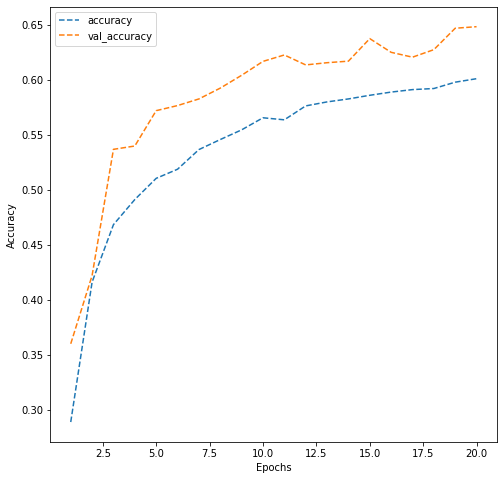

In [ ]:
# Evaluating model on test data.

dict_hist = history_model1_gs.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

**Observations:**


*   Validation accuracy is higher than test accuracy.
*   This indicates high bias and underfitting. It can also result from use of dropout.
*   Solutions might include longer training periods. Ideally, much cleaner dataset also, to reduce noise.











**RGB CNN Model 1**

In [ ]:
#RGB

def cnn_model_1():
  model = Sequential()

  model.add(Conv2D(filters = 64, kernel_size = (2,2), padding = "same", input_shape = (48, 48, 3), activation = 'relu'))  #rgb
  model.add(MaxPooling2D(pool_size = (2,2))) #max-pooling layer with a pool size of 2x2
  model.add(Dropout(0.2)) #Add the Dropout layer with the rate equal to 0.2

  model.add(Conv2D(filters = 32, kernel_size = (2,2), padding = "same", activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2))) #max-pooling layer with a pool size of 2x2
  model.add(Dropout(0.2)) #Add the Dropout layer with the rate equal to 0.2

  model.add(Conv2D(filters = 32, kernel_size = (2,2), padding = "same", activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2))) #max-pooling layer with a pool size of 2x2
  model.add(Dropout(0.4)) #Add the Dropout layer with the rate equal to 0.4

  model.add(Flatten())

  model.add(Dense(512, activation = 'relu'))

  model.add(Dropout(0.4))

  model.add(Dense(4, activation = 'softmax'))
  return model



In [ ]:
#building model, storing in new variable
rgb_model1 = cnn_model_1()

In [ ]:
#hyperparamaters

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model1.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20

In [ ]:

rgb_model1.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])   

In [ ]:

rgb_model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 48, 48, 64)        832       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 32)        8224      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 12, 12, 32)       

In [ ]:

history_model1_rgb = rgb_model1.fit(train_set, validation_data = validation_set, verbose = 1, epochs = 20, use_multiprocessing = True, batch_size = 32)

Epoch 1/20
473/473 [==============================] - 29s 59ms/step - loss: 1.3553 - accuracy: 0.3135 - val_loss: 1.2956 - val_accuracy: 0.3884
Epoch 2/20
473/473 [==============================] - 26s 56ms/step - loss: 1.2517 - accuracy: 0.4241 - val_loss: 1.1803 - val_accuracy: 0.4937
Epoch 3/20
473/473 [==============================] - 26s 55ms/step - loss: 1.1724 - accuracy: 0.4770 - val_loss: 1.1027 - val_accuracy: 0.5381
Epoch 4/20
473/473 [==============================] - 29s 60ms/step - loss: 1.1193 - accuracy: 0.5041 - val_loss: 1.0230 - val_accuracy: 0.5666
Epoch 5/20
473/473 [==============================] - 31s 65ms/step - loss: 1.0777 - accuracy: 0.5258 - val_loss: 0.9902 - val_accuracy: 0.5899
Epoch 6/20
473/473 [==============================] - 28s 58ms/step - loss: 1.0520 - accuracy: 0.5397 - val_loss: 0.9604 - val_accuracy: 0.6026
Epoch 7/20
473/473 [==============================] - 27s 56ms/step - loss: 1.0323 - accuracy: 0.5540 - val_loss: 0.9387 - val_accuracy:

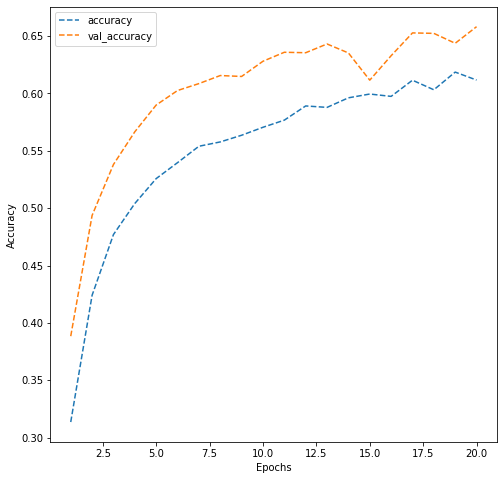

In [ ]:


rgb_dict_hist = history_model1_rgb.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, rgb_dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, rgb_dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

**comparing grayscale to RGB** There is very little difference. Though the RGB creates additional data, it is possible the dropout is too high still.
<br> I believe that nothing is gained from the RGB option.


 **Second Convolutional Neural Network**

**CNN Model 2, grayscale**

In [ ]:
# Creating sequential model, without dropout

def cnn_model_2():

    model = Sequential()
 

    model.add(Conv2D(filters = 256, kernel_size = (2,2), padding = "same", input_shape = (48, 48, 1), activation = 'relu'))   #grayscale
    model.add(BatchNormalization())            #BatchNormalization layer
    model.add(LeakyReLU(0.1))                  #LeakyRelU layer with Leaky ReLU parameter of 0.1
    model.add(MaxPooling2D(pool_size = (2,2))) #max-pooling layer with a pool size of 2x2


    model.add(Conv2D(filters = 128, kernel_size = (2,2), padding = "same", activation = 'relu'))   
    model.add(BatchNormalization())            #BatchNormalization layer
    model.add(LeakyReLU(0.1))                  #LeakyRelU layer with Leaky ReLU parameter of 0.1
    model.add(MaxPooling2D(pool_size = (2,2))) #max-pooling layer with a pool size of 2x2

    
    model.add(Conv2D(filters = 64, kernel_size = (2,2), padding = "same", activation = 'relu'))   
    model.add(BatchNormalization())            #BatchNormalization layer
    model.add(LeakyReLU(0.1))                  #LeakyRelU layer with Leaky ReLU parameter of 0.1
    model.add(MaxPooling2D(pool_size = (2,2))) #max-pooling layer with a pool size of 2x2

    
    model.add(Conv2D(filters = 32, kernel_size = (2,2), padding = "same", activation = 'relu'))   
    model.add(BatchNormalization())            #BatchNormalization layer
    model.add(LeakyReLU(0.1))                  #LeakyRelU layer with Leaky ReLU parameter of 0.1
    model.add(MaxPooling2D(pool_size = (2,2))) #max-pooling layer with a pool size of 2x2

   
    model.add(Flatten())

    
    model.add(Dense(512, activation = 'relu'))   #first Dense layer with 512 neurons. Use 'relu' activation function.
    model.add(Dense(128, activation = 'relu'))   #Add the second Dense Layer with 128 neurons and use 'relu' activation function.
    model.add(Dense(4, activation = 'softmax'))   #Add your final Dense Layer with 4 neurons and 'softmax' activation function

    return model






In [ ]:
 
    model2 = cnn_model_2()

In [ ]:

    model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 256)       1280      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 256)      1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 256)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model2.h5", monitor='val_loss', verbose = 1, save_best_only = True, mode = 'auto')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )                             

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.001)       

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20



In [ ]:
model2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])   

**RGB CNN Model 2:**

In [ ]:
#history_model2_rgb = model2.fit(train_set, validation_data = validation_set, epochs = 20, verbose = 1, use_multiprocessing = True, batch_size = 32)

Epoch 1/20
945/945 [==============================] - ETA: 0s - loss: 1.1895 - accuracy: 0.4483

In [ ]:

dict_hist = history_model2_rgb.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

**Model for RGB images**

adding backend clearing

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

The next is same as above, but with more epochs. It is still underfitting.

In [ ]:

#grayscale

history_model2_gs = model2.fit(train_set, validation_data = validation_set, epochs = 40, verbose = 1, use_multiprocessing = True, batch_size = 32, callbacks=callbacks_list)

Epoch 1/40
473/473 [==============================] - 41s 70ms/step - loss: 1.2690 - accuracy: 0.3981 - val_loss: 1.2983 - val_accuracy: 0.4191
Epoch 2/40
473/473 [==============================] - 33s 70ms/step - loss: 1.0634 - accuracy: 0.5278 - val_loss: 1.1771 - val_accuracy: 0.4631
Epoch 3/40
473/473 [==============================] - 30s 64ms/step - loss: 0.9722 - accuracy: 0.5793 - val_loss: 0.9450 - val_accuracy: 0.5923
Epoch 4/40
473/473 [==============================] - 31s 64ms/step - loss: 0.9115 - accuracy: 0.6050 - val_loss: 1.0798 - val_accuracy: 0.5284
Epoch 5/40
473/473 [==============================] - 31s 65ms/step - loss: 0.8705 - accuracy: 0.6247 - val_loss: 0.9224 - val_accuracy: 0.6138
Epoch 6/40
473/473 [==============================] - 30s 63ms/step - loss: 0.8234 - accuracy: 0.6489 - val_loss: 0.9608 - val_accuracy: 0.5996
Epoch 7/40
473/473 [==============================] - 30s 63ms/step - loss: 0.8026 - accuracy: 0.6624 - val_loss: 0.8437 - val_accuracy:

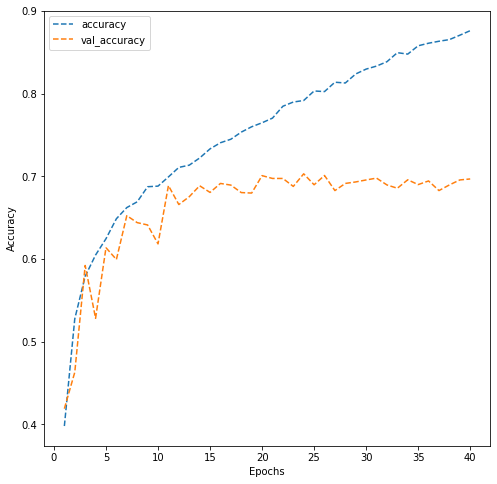

In [ ]:

dict_hist = history_model2_gs.history

list_ep = [i for i in range(1, 41)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

In [ ]:
model2_rgb.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])   

In [ ]:
model2_rgb.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        832       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 32)        8224      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 12, 12, 32)       

In [ ]:

  #weighted classes
  model2_wc = cnn_model_2()

In [ ]:

model2_wc.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])   

In [ ]:

 class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.25}

history_model2_wc = model2_wc.fit(train_set, validation_data = validation_set, epochs = 20, verbose = 1, class_weight = class_weights, use_multiprocessing = True, batch_size = 32)

Epoch 1/20
473/473 [==============================] - 28s 42ms/step - loss: 1.3406 - accuracy: 0.3925 - val_loss: 1.2898 - val_accuracy: 0.3968
Epoch 2/20
473/473 [==============================] - 20s 42ms/step - loss: 1.0990 - accuracy: 0.5345 - val_loss: 1.1387 - val_accuracy: 0.5083
Epoch 3/20
473/473 [==============================] - 20s 41ms/step - loss: 0.9947 - accuracy: 0.5840 - val_loss: 1.0323 - val_accuracy: 0.5204
Epoch 4/20
473/473 [==============================] - 19s 40ms/step - loss: 0.9244 - accuracy: 0.6160 - val_loss: 0.9790 - val_accuracy: 0.5919
Epoch 5/20
473/473 [==============================] - 19s 40ms/step - loss: 0.8731 - accuracy: 0.6386 - val_loss: 0.8968 - val_accuracy: 0.6182
Epoch 6/20
473/473 [==============================] - 20s 41ms/step - loss: 0.8411 - accuracy: 0.6567 - val_loss: 0.9757 - val_accuracy: 0.5837
Epoch 7/20
473/473 [==============================] - 20s 42ms/step - loss: 0.8123 - accuracy: 0.6669 - val_loss: 0.8579 - val_accuracy:

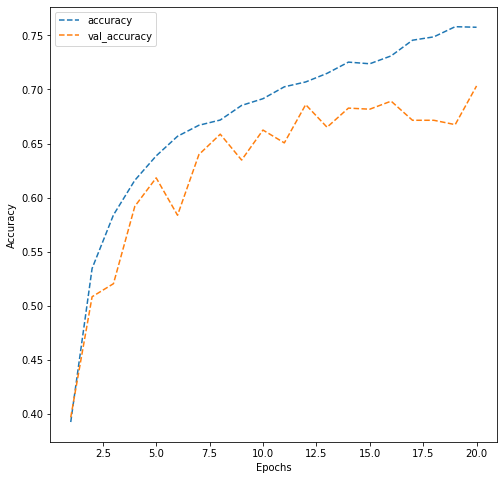

In [ ]:

dict_hist = history_model2_wc.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

underfitting here

**Now, working to improve model 2**
There are many variations below, some better documented than others. No strong models found yet.

In [6]:

def cnn_model_3():

    model = Sequential()
 

    model.add(Conv2D(filters = 36, kernel_size = (2,2), padding = "same", input_shape = (48, 48, 1), activation = 'relu'))   #grayscale
    model.add(BatchNormalization())            #BatchNormalization layer
    model.add(LeakyReLU(0.1))                  #LeakyRelU layer with Leaky ReLU parameter of 0.1
    model.add(MaxPooling2D(pool_size = (2,2))) #max-pooling layer with a pool size of 2x2
    model.add(Dropout(0.2))                       #adding dropout
  


    model.add(Conv2D(filters = 64, kernel_size = (2,2), padding = "same", activation = 'relu'))   
    model.add(BatchNormalization())            #BatchNormalization layer
    model.add(LeakyReLU(0.1))                  #LeakyRelU layer with Leaky ReLU parameter of 0.1
    model.add(MaxPooling2D(pool_size = (2,2))) #max-pooling layer with a pool size of 2x2
    model.add(Dropout(0.2))                       #adding dropout

    
    model.add(Conv2D(filters = 128, kernel_size = (2,2), padding = "same", activation = 'relu'))   
    model.add(BatchNormalization())            #BatchNormalization layer
    model.add(LeakyReLU(0.1))                  #LeakyRelU layer with Leaky ReLU parameter of 0.1
    model.add(MaxPooling2D(pool_size = (2,2))) #max-pooling layer with a pool size of 2x2
    model.add(Dropout(0.2))                       #adding dropout        

    
    model.add(Conv2D(filters = 256, kernel_size = (2,2), padding = "same", activation = 'relu'))   
    model.add(BatchNormalization())            #BatchNormalization layer
    model.add(LeakyReLU(0.1))                  #LeakyRelU layer with Leaky ReLU parameter of 0.1
    model.add(MaxPooling2D(pool_size = (2,2))) #max-pooling layer with a pool size of 2x2
    model.add(Dropout(0.2))                       #adding dropout
   
    model.add(Flatten())

#Dense layers

    model.add(Dense(512, activation = 'relu'))   #first Dense layer with 512 neurons. Use 'relu' activation function.
    model.add(Dropout(0.5))                  
    model.add(Dense(128, activation = 'relu'))   #Add the second Dense Layer with 128 neurons and use 'relu' activation function.
    model.add(Dropout(0.5))
    model.add(Dense(4, activation = 'softmax'))   #final Dense Layer with 4 neurons and 'softmax' activation function

    return model






In [7]:

    model3 = cnn_model_3()

In [ ]:
    model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 36)        180       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 36)       144       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 36)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 36)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 36)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        9

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model2.h5", monitor='val_loss', verbose = 1, save_best_only = True, mode = 'auto')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 40,
                          verbose = 1,
                          restore_best_weights = True
                          )                             

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 40,
                              verbose = 1,
                              min_delta = 0.001)       

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20



In [8]:
model3.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])   

In [ ]:
history_model3 = model3.fit(train_set, validation_data = validation_set, epochs = 20, verbose = 1,  batch_size = 32)

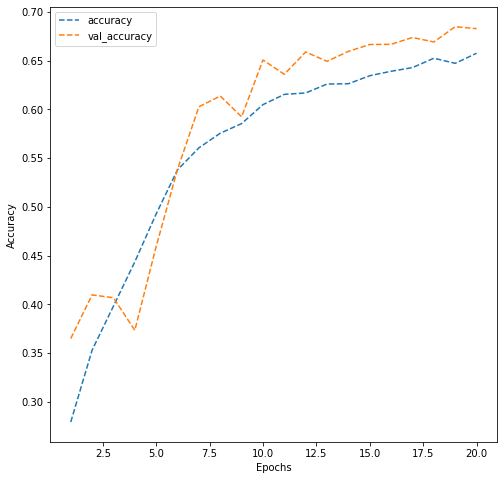

In [ ]:

dict_hist = history_model3.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

**with drop out, rates between 2 and 4**

In [ ]:
 # what does 100 epochs look like

 class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.25}

history_model4 = model3.fit(train_set, validation_data = validation_set, epochs = 100, verbose = 1, class_weight = class_weights, use_multiprocessing = True, batch_size = 32)

Epoch 1/100
473/473 [==============================] - 20s 42ms/step - loss: 0.8379 - accuracy: 0.6558 - val_loss: 0.7862 - val_accuracy: 0.6817
Epoch 2/100
473/473 [==============================] - 20s 41ms/step - loss: 0.8232 - accuracy: 0.6672 - val_loss: 0.7752 - val_accuracy: 0.6779
Epoch 3/100
473/473 [==============================] - 21s 45ms/step - loss: 0.8244 - accuracy: 0.6600 - val_loss: 0.8166 - val_accuracy: 0.6610
Epoch 4/100
473/473 [==============================] - 20s 42ms/step - loss: 0.8225 - accuracy: 0.6613 - val_loss: 0.7882 - val_accuracy: 0.6833
Epoch 5/100
473/473 [==============================] - 19s 41ms/step - loss: 0.8146 - accuracy: 0.6674 - val_loss: 0.7779 - val_accuracy: 0.6835
Epoch 6/100
473/473 [==============================] - 20s 42ms/step - loss: 0.8103 - accuracy: 0.6693 - val_loss: 0.8307 - val_accuracy: 0.6635
Epoch 7/100
473/473 [==============================] - 20s 42ms/step - loss: 0.8009 - accuracy: 0.6726 - val_loss: 0.8080 - val_ac

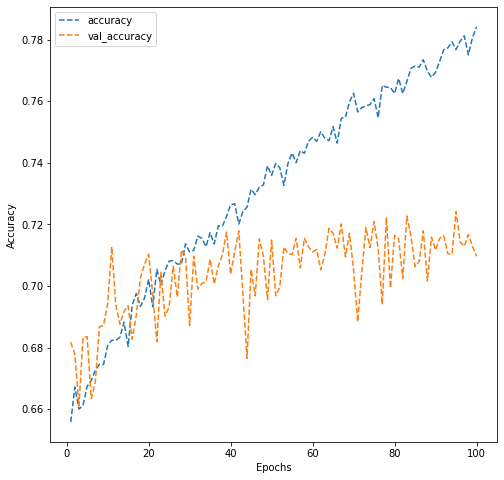

In [ ]:

dict_hist = history_model4.history

list_ep = [i for i in range(1, 101)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

In [ ]:

 class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.25}

history_model_best = model6.fit(train_set, validation_data = validation_set, epochs = 20, verbose = 1, class_weight = class_weights, use_multiprocessing = True, batch_size = 32)

In [ ]:
# evaluating model 6 on test data.

dict_hist = history_model_best.history

list_ep = [i for i in range(1, 126)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

Changing to RGB, to increase data, potentially redcue overfitting

In [ ]:

 class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.25}

history_model8 = model6.fit(train_set, validation_data = validation_set, epochs = 40, verbose = 1, class_weight = class_weights, use_multiprocessing = True, batch_size = 32)

Epoch 1/40
473/473 [==============================] - 30s 63ms/step - loss: 0.1767 - accuracy: 0.9395 - val_loss: 1.6786 - val_accuracy: 0.6936
Epoch 2/40
473/473 [==============================] - 30s 63ms/step - loss: 0.1745 - accuracy: 0.9402 - val_loss: 1.7670 - val_accuracy: 0.6833
Epoch 3/40
473/473 [==============================] - 32s 67ms/step - loss: 0.1819 - accuracy: 0.9382 - val_loss: 1.7146 - val_accuracy: 0.6894
Epoch 4/40
473/473 [==============================] - 33s 69ms/step - loss: 0.1732 - accuracy: 0.9410 - val_loss: 1.6861 - val_accuracy: 0.6914
Epoch 5/40
473/473 [==============================] - 31s 65ms/step - loss: 0.1615 - accuracy: 0.9431 - val_loss: 1.8222 - val_accuracy: 0.6956
Epoch 6/40
473/473 [==============================] - 31s 65ms/step - loss: 0.1886 - accuracy: 0.9343 - val_loss: 1.4656 - val_accuracy: 0.6942
Epoch 7/40
473/473 [==============================] - 30s 63ms/step - loss: 0.1819 - accuracy: 0.9358 - val_loss: 1.6450 - val_accuracy:

In [ ]:
# evaluating model 8 on test data.

dict_hist = history_model8.history

list_ep = [i for i in range(1, 41)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

another go, more drop out, greyscale

In [ ]:
 #building model, storing in new variable

    #greyscale, dropout, and changes to layers
model9 = cnn_model_3()

In [ ]:
model9.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])   

In [ ]:

 class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.25}

history_model9 = model9.fit(train_set, validation_data = validation_set, epochs = 20, verbose = 1, class_weight = class_weights, use_multiprocessing = True, batch_size = 32)

In [ ]:
# evaluating model 9 on test data.

dict_hist = history_model9.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

same as above but without class weights

In [ ]:

# class_weights = {
 #   0: 1.0,
  #  1: 1.0,
   # 2: 1.0,
    #3: 1.25}

history_model10 = model9.fit(train_set, validation_data = validation_set, epochs = 20, verbose = 1, use_multiprocessing = True, batch_size = 32)

Epoch 1/20
473/473 [==============================] - 19s 40ms/step - loss: 0.6476 - accuracy: 0.7298 - val_loss: 0.7462 - val_accuracy: 0.7038
Epoch 2/20
473/473 [==============================] - 18s 39ms/step - loss: 0.6348 - accuracy: 0.7358 - val_loss: 0.8158 - val_accuracy: 0.6815
Epoch 3/20
473/473 [==============================] - 19s 39ms/step - loss: 0.6322 - accuracy: 0.7383 - val_loss: 0.7386 - val_accuracy: 0.7006
Epoch 4/20
473/473 [==============================] - 20s 42ms/step - loss: 0.6199 - accuracy: 0.7387 - val_loss: 0.7486 - val_accuracy: 0.7002
Epoch 5/20
473/473 [==============================] - 20s 42ms/step - loss: 0.6047 - accuracy: 0.7474 - val_loss: 0.7292 - val_accuracy: 0.7161
Epoch 6/20
473/473 [==============================] - 19s 39ms/step - loss: 0.6024 - accuracy: 0.7504 - val_loss: 0.7417 - val_accuracy: 0.7000
Epoch 7/20
473/473 [==============================] - 18s 39ms/step - loss: 0.5901 - accuracy: 0.7513 - val_loss: 0.7224 - val_accuracy:

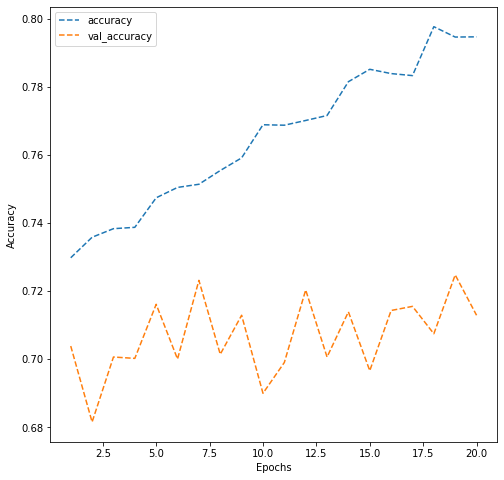

In [ ]:
# evaluating model 9 on test data.

dict_hist = history_model10.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

without class weights, 400 epochs


---
It was clear that the model would not improve beyond its overfitting, so it was terminated early.



In [ ]:

# class_weights = {
 #   0: 1.0,
  #  1: 1.0,
   # 2: 1.0,
    #3: 1.25}

history_model10 = model9.fit(train_set, validation_data = validation_set, epochs = 400, verbose = 1, use_multiprocessing = True, batch_size = 32)

In [ ]:
# evaluating model 9 on test data.

dict_hist = history_model10.history

list_ep = [i for i in range(1, 188)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

with class weights again, 400 epochs


---

Also significant overfit, so terminated early

In [ ]:

 class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.25}

history_model9 = model9.fit(train_set, validation_data = validation_set, epochs = 400, verbose = 1, class_weight = class_weights, use_multiprocessing = True, batch_size = 32)

Epoch 1/400
473/473 [==============================] - 22s 41ms/step - loss: 1.4281 - accuracy: 0.3452 - val_loss: 1.3159 - val_accuracy: 0.3625
Epoch 2/400
473/473 [==============================] - 23s 49ms/step - loss: 1.1766 - accuracy: 0.4844 - val_loss: 1.0847 - val_accuracy: 0.5471
Epoch 3/400
473/473 [==============================] - 21s 44ms/step - loss: 1.0352 - accuracy: 0.5624 - val_loss: 1.0280 - val_accuracy: 0.5598
Epoch 4/400
473/473 [==============================] - 18s 38ms/step - loss: 0.9753 - accuracy: 0.5937 - val_loss: 1.0250 - val_accuracy: 0.5533
Epoch 5/400
473/473 [==============================] - 18s 38ms/step - loss: 0.9016 - accuracy: 0.6300 - val_loss: 0.8404 - val_accuracy: 0.6610
Epoch 6/400
473/473 [==============================] - 19s 40ms/step - loss: 0.8757 - accuracy: 0.6382 - val_loss: 0.8635 - val_accuracy: 0.6434
Epoch 7/400
473/473 [==============================] - 18s 38ms/step - loss: 0.8505 - accuracy: 0.6537 - val_loss: 0.8241 - val_ac

KeyboardInterrupt: ignored

In [ ]:
# evaluating model 9 on test data.

dict_hist = history_model10.history

list_ep = [i for i in range(1, 257)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

added drop out layers & increased all to .5

In [ ]:
model3.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics=['accuracy'])   

no weights, 40 epochs

In [ ]:

# class_weights = {
 #   0: 1.0,
  #  1: 1.0,
   # 2: 1.0,
    #3: 1.25}

history_model10 = model9.fit(train_set, validation_data = validation_set, epochs = 40, verbose = 1, use_multiprocessing = True, batch_size = 32)

Epoch 1/40
473/473 [==============================] - 21s 43ms/step - loss: 0.1114 - accuracy: 0.9585 - val_loss: 1.0379 - val_accuracy: 0.7370
Epoch 2/40
473/473 [==============================] - 18s 38ms/step - loss: 0.1088 - accuracy: 0.9611 - val_loss: 1.0321 - val_accuracy: 0.7398
Epoch 3/40
473/473 [==============================] - 18s 39ms/step - loss: 0.1120 - accuracy: 0.9596 - val_loss: 1.1024 - val_accuracy: 0.7388
Epoch 4/40
473/473 [==============================] - 18s 38ms/step - loss: 0.1128 - accuracy: 0.9585 - val_loss: 1.1170 - val_accuracy: 0.7328
Epoch 5/40
473/473 [==============================] - 18s 38ms/step - loss: 0.1128 - accuracy: 0.9589 - val_loss: 1.0013 - val_accuracy: 0.7356
Epoch 6/40
473/473 [==============================] - 21s 44ms/step - loss: 0.1100 - accuracy: 0.9585 - val_loss: 1.0736 - val_accuracy: 0.7412
Epoch 7/40
473/473 [==============================] - 19s 39ms/step - loss: 0.1173 - accuracy: 0.9580 - val_loss: 0.9784 - val_accuracy:

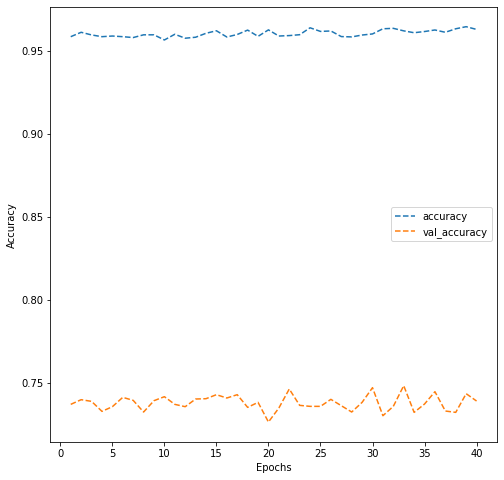

In [ ]:
# evaluating model 9 on test data.

dict_hist = history_model10.history

list_ep = [i for i in range(1, 41)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

same, with weights, 30 epochs

In [ ]:

 class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.25}

history_model10 = model9.fit(train_set, validation_data = validation_set, epochs = 30, verbose = 1, class_weight = class_weights, use_multiprocessing = True, batch_size = 32)

Epoch 1/30
473/473 [==============================] - 19s 39ms/step - loss: 0.1078 - accuracy: 0.9626 - val_loss: 1.1340 - val_accuracy: 0.7326
Epoch 2/30
473/473 [==============================] - 18s 38ms/step - loss: 0.1036 - accuracy: 0.9635 - val_loss: 1.1083 - val_accuracy: 0.7338
Epoch 3/30
473/473 [==============================] - 19s 40ms/step - loss: 0.1118 - accuracy: 0.9621 - val_loss: 1.1573 - val_accuracy: 0.7241
Epoch 4/30
473/473 [==============================] - 20s 42ms/step - loss: 0.1105 - accuracy: 0.9611 - val_loss: 1.0799 - val_accuracy: 0.7362
Epoch 5/30
473/473 [==============================] - 18s 38ms/step - loss: 0.1086 - accuracy: 0.9621 - val_loss: 1.0909 - val_accuracy: 0.7348
Epoch 6/30
473/473 [==============================] - 18s 37ms/step - loss: 0.1020 - accuracy: 0.9624 - val_loss: 1.1394 - val_accuracy: 0.7398
Epoch 7/30
473/473 [==============================] - 18s 38ms/step - loss: 0.1056 - accuracy: 0.9627 - val_loss: 1.0699 - val_accuracy:

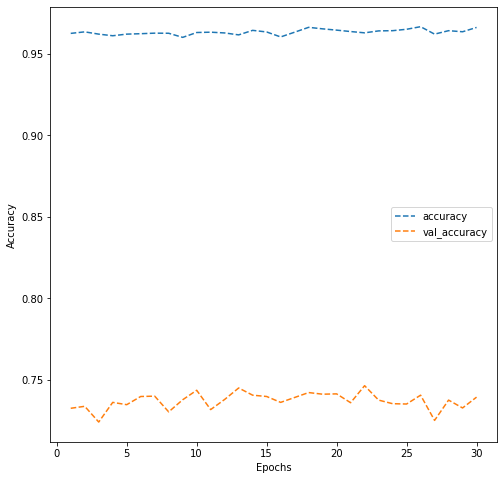

In [ ]:
# evaluating model 9 on test data.

dict_hist = history_model10.history

list_ep = [i for i in range(1, 31)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

same, but rgb

In [ ]:

 class_weights = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.25}

history_model10 = model9.fit(train_set, validation_data = validation_set, epochs = 30, verbose = 1, class_weight = class_weights, use_multiprocessing = True, batch_size = 32)

Epoch 1/30
473/473 [==============================] - 28s 60ms/step - loss: 0.0959 - accuracy: 0.9660 - val_loss: 1.1326 - val_accuracy: 0.7380
Epoch 2/30
473/473 [==============================] - 28s 59ms/step - loss: 0.0938 - accuracy: 0.9655 - val_loss: 1.2645 - val_accuracy: 0.7416
Epoch 3/30
473/473 [==============================] - 29s 61ms/step - loss: 0.0911 - accuracy: 0.9674 - val_loss: 1.1679 - val_accuracy: 0.7430
Epoch 4/30
473/473 [==============================] - 31s 65ms/step - loss: 0.0965 - accuracy: 0.9658 - val_loss: 1.1626 - val_accuracy: 0.7412
Epoch 5/30
473/473 [==============================] - 27s 58ms/step - loss: 0.1015 - accuracy: 0.9650 - val_loss: 1.0706 - val_accuracy: 0.7306
Epoch 6/30
473/473 [==============================] - 27s 58ms/step - loss: 0.0948 - accuracy: 0.9655 - val_loss: 1.1380 - val_accuracy: 0.7253
Epoch 7/30
473/473 [==============================] - 28s 59ms/step - loss: 0.1005 - accuracy: 0.9637 - val_loss: 1.1157 - val_accuracy:

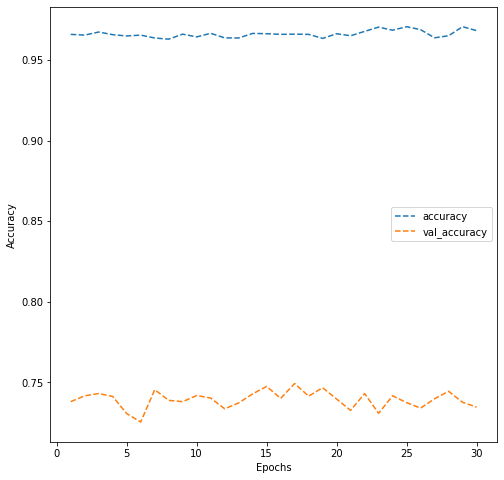

In [ ]:
# evaluating model 9 on test data.

dict_hist = history_model10.history

list_ep = [i for i in range(1, 31)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

In [ ]:


history_model10 = model9.fit(train_set, validation_data = validation_set, epochs = 30, verbose = 1, use_multiprocessing = True, batch_size = 32)

Epoch 1/30
473/473 [==============================] - 38s 61ms/step - loss: 1.6073 - accuracy: 0.2622 - val_loss: 1.3619 - val_accuracy: 0.2670
Epoch 2/30
473/473 [==============================] - 28s 59ms/step - loss: 1.3877 - accuracy: 0.2596 - val_loss: 1.3607 - val_accuracy: 0.2915
Epoch 3/30
473/473 [==============================] - 28s 59ms/step - loss: 1.3851 - accuracy: 0.2555 - val_loss: 1.3627 - val_accuracy: 0.3621
Epoch 4/30
473/473 [==============================] - 29s 61ms/step - loss: 1.3840 - accuracy: 0.2595 - val_loss: 1.3601 - val_accuracy: 0.3544
Epoch 5/30
473/473 [==============================] - 28s 58ms/step - loss: 1.3831 - accuracy: 0.2624 - val_loss: 1.3610 - val_accuracy: 0.2735
Epoch 6/30
473/473 [==============================] - 30s 63ms/step - loss: 1.3833 - accuracy: 0.2641 - val_loss: 1.3648 - val_accuracy: 0.2654
Epoch 7/30
473/473 [==============================] - 28s 58ms/step - loss: 1.3825 - accuracy: 0.2628 - val_loss: 1.3669 - val_accuracy:

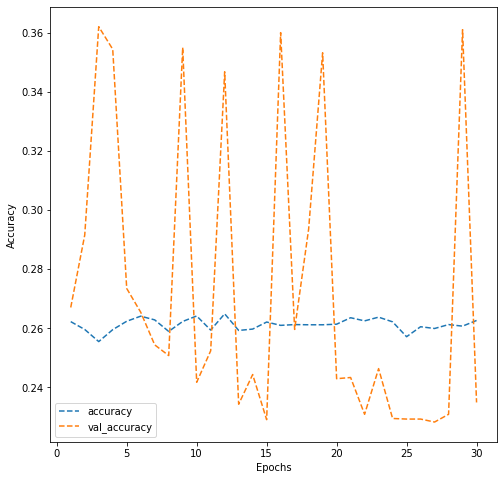

In [ ]:
# evaluating model 9 on test data.

dict_hist = history_model10.history

list_ep = [i for i in range(1, 31)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()

In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

**Here is a series of models, three are pretrained learners, and one is a slightly more robust CNN**

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import os
!pip install keras-cv
import tensorflow
from tensorflow import keras
from keras.utils import image_dataset_from_directory
import keras_cv

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import LearningRateScheduler
#from tensorflow.keras import math

Trying new

In [ ]:
#clearing backend
#keras.backend.clear_session()

In [ ]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Facial_emotion_images.zip'


#with zipfile.ZipFile(path, 'r') as zip_ref:
 #   zip_ref.extractall()

In [ ]:
picture_size = 48
folder_path = "Facial_emotion_images/"

Data loader for first three models

In [ ]:
batch_size  = 32              #The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'. 
img_size = 48



datagen_train = ImageDataGenerator(horizontal_flip = True,            #train set
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',              #below find 'grayscale' then 'rgb' as color modes
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              
                                              shuffle = True)


datagen_validation = ImageDataGenerator(horizontal_flip = True,       #validation set
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

validation_set = datagen_validation.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',               #color mode
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              
                                              shuffle = True)


datagen_test = ImageDataGenerator(horizontal_flip = True,           #test set
                                    brightness_range=(0.,2.),
                                    rescale=1./255,
                                    shear_range=0.3)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',              #color mode               
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                           
                                              shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


In [ ]:

#Data loader for the CNN, written by Aldo Tapia

batch_size  = 32
img_size = 48
from keras.utils import image_dataset_from_directory
import keras_cv

train_set = image_dataset_from_directory(
directory = folder_path + "train",
labels="inferred", # from subfolder
label_mode="categorical", # for `categorical_crossentropy`
class_names=['happy', 'sad', 'neutral', 'surprise'], # same
color_mode="rgb", # same                              change to RGB except for CNN
batch_size=batch_size, # same
image_size=(img_size, img_size), # same
shuffle=True, # same option than old code
seed=123, # my seed
validation_split=None, # we don't need it
subset=None, # no validation split
interpolation="nearest", # flow_from_directory default method crop_to_aspect_ratio=False, # square images
)

train_set = train_set.map(lambda x, y: (keras.layers.RandomFlip()(x), y))  
train_set = train_set.map(lambda x, y: (keras.layers.RandomBrightness(2./255)(x),y))
train_set = train_set.map(lambda x, y: (keras_cv.layers.RandomShear(0,0.3)(x),y))
train_set = train_set.map(lambda x, y: (keras.layers.Rescaling(1./255)(x), y))

validation_set = image_dataset_from_directory(
directory = folder_path + "validation",
labels="inferred", # from subfolder
label_mode="categorical", # for `categorical_crossentropy`
class_names=['happy', 'sad', 'neutral', 'surprise'], # same
color_mode="rgb", # same              change to RGB except for CNN
batch_size=batch_size, # same
image_size=(img_size, img_size), # same
shuffle=True, # same option than old code    #I tried as False for post-model analysis
seed=123, # my seed
validation_split=None, # we don't need it
subset=None, # no validation split
interpolation="nearest", # flow_from_directory default method crop_to_aspect_ratio=False, # square images
)

validation_set = validation_set.map(lambda x, y: (keras.layers.RandomFlip()(x), y)) 
validation_set = validation_set.map(lambda x, y: (keras.layers.RandomBrightness(2./255)(x),y))
validation_set = validation_set.map(lambda x, y: (keras_cv.layers.RandomShear(0,0.3)(x), y))
validation_set = validation_set.map(lambda x, y: (keras.layers.Rescaling(1./255)(x), y))

test_set = image_dataset_from_directory(
directory = folder_path + "test",
labels="inferred", # from subfolder
label_mode="categorical", # for `categorical_crossentropy`
class_names=['happy', 'sad', 'neutral', 'surprise'], # same
color_mode="rgb", # same                              change to RGB except for CNN
batch_size=batch_size, # same
image_size=(img_size, img_size), # same
shuffle=True, # same option than old code
seed=123, # my seed
validation_split=None, # we don't need it
subset=None, # no validation split
interpolation="nearest", # flow_from_directory default method crop_to_aspect_ratio=False, # square images
)

test_set = test_set.map(lambda x, y: (keras.layers.RandomFlip()(x), y))
test_set = test_set.map(lambda x, y: (keras.layers.RandomBrightness(2./255)(x),y))
test_set = test_set.map(lambda x, y: (keras_cv.layers.RandomShear(0,0.3)(x), y))
test_set = test_set.map(lambda x, y: (keras.layers.Rescaling(1./255)(x), y))

Found 15109 files belonging to 4 classes.
Found 4977 files belonging to 4 classes.
Found 128 files belonging to 4 classes.


In [ ]:
(4, 100, 100, 3) tf.Tensor([0 0 0 0], shape=(4,), dtype=int32)

## **VGG16 Model**

### **Importing the VGG16 Architecture**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [ ]:
# Getting only the conv layers for transfer learning.
transfer_layer = vgg.get_layer('block5_pool')
vgg_model = Model(inputs=vgg.input, outputs=transfer_layer.output)
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:


vgg.trainable = False


vgg_model = Model(inputs=vgg.input, outputs=transfer_layer.output)

x = Flatten()(transfer_layer.output)

x = Dense(256, activation = 'relu')(x)

x = Dense(128, activation = 'relu')(x)

x = Dropout(0.3)(x)

x = Dense(64, activation = 'relu')(x)

x = BatchNormalization()(x)

pred = Dense(4, activation='softmax')(x)

vgg_model = Model(vgg.input, pred) 

### **Compiling and Training the VGG16 Model**

In [ ]:
vgg_model.compile(optimizer = Adam(learning_rate = 0.005), 
                 loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
vgg_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [ ]:
start = time.time()

vgg_history = vgg_model.fit(train_set, 
                       validation_data = validation_set,  
                       epochs=20,
                       batch_size = 32, use_multiprocessing = True)

end = time.time()
print(f'{end - start} seconds')

Epoch 1/20
473/473 [==============================] - 25s 52ms/step - loss: 1.0755 - accuracy: 0.5298 - val_loss: 1.1304 - val_accuracy: 0.5019
Epoch 2/20
473/473 [==============================] - 25s 52ms/step - loss: 1.0667 - accuracy: 0.5376 - val_loss: 1.0965 - val_accuracy: 0.5188
Epoch 3/20
473/473 [==============================] - 25s 52ms/step - loss: 1.0683 - accuracy: 0.5355 - val_loss: 1.1104 - val_accuracy: 0.5049
Epoch 4/20
473/473 [==============================] - 25s 52ms/step - loss: 1.0589 - accuracy: 0.5367 - val_loss: 1.1184 - val_accuracy: 0.4963
Epoch 5/20
473/473 [==============================] - 25s 52ms/step - loss: 1.0553 - accuracy: 0.5406 - val_loss: 1.1355 - val_accuracy: 0.4876
Epoch 6/20
473/473 [==============================] - 25s 52ms/step - loss: 1.0489 - accuracy: 0.5428 - val_loss: 1.0974 - val_accuracy: 0.5196
Epoch 7/20
473/473 [==============================] - 25s 52ms/step - loss: 1.0510 - accuracy: 0.5487 - val_loss: 1.1862 - val_accuracy:

In [ ]:
#clearing backend
#keras.backend.clear_session()

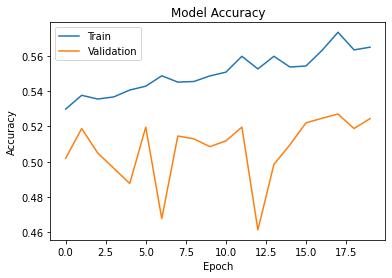

In [ ]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()


### **Evaluating the VGG16 model**

In [ ]:
vgg_dict_history = vgg_history.history

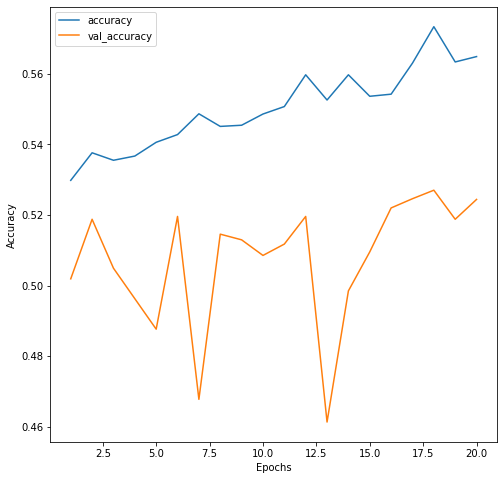

In [ ]:
vgg_dict_hist = vgg_history.history

#list_ep = [i for i in range(1, len(dict_hist['lr'])+1)]

list_ep = [i for i in range(1, 21)]   #adjust for number of epochs

plt.figure(figsize = (8, 8))

plt.plot(list_ep, vgg_dict_hist['accuracy'],  label = 'accuracy') 

plt.plot(list_ep, vgg_dict_hist['val_accuracy'],  label = 'val_accuracy') 

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()



In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

In [ ]:
# Importing required functions

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

for x, y in test_set:
  predictions = np.concatenate([predictions, np.argmax(vgg_model.predict(x), axis=-1)])
  labels = np.concatenate([labels, np.argmax(vgg_model(test_set), axis=-1)])
  
  print(classification_report(labels, predictions))


# Plotting the heatmap using confusion matrix

cm = confusion_matrix(labels, predictions)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f')

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

In [ ]:
predictions = np.array([]) 
labels = np.array([]) 

for x, y in test_set:
  predictions = np.concatenate([predictions, np.argmax(vgg_model.predict(x),axis=-1)])
  labels = np.concatenate([labels, np.argmax(vgg_model.predict(y), axis=-1)])
print(classification_report(labels, predictions))

cm = confusion_matrix(labels, predictions)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f',
            xticklabels = ['happy', 'sad', 'neutral', 'surprise'],
            yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
test_pred = vgg_model.predict(test_set)


test_pred = np.argmax(test_pred, axis = -1)

4/4 [==============================] - 0s 43ms/step


**Observations and Insights:**


*   overfitting
*   but not so terribly off the same trajectory



## **ResNet V2 Model**

In [ ]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model

Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))
Resnet.summary()

171446536/171446536 [==============================] - 1s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                       

In [ ]:
transfer_layer_Resnet = Resnet.get_layer('conv5_block3_add')
Resnet.trainable=False

x = Flatten()(transfer_layer_Resnet.output)

x = Dense(256, activation = 'relu')(x)

x = Dense(128, activation = 'relu')(x)

x = Dropout(0.3)(x)

x = Dense(64, activation = 'relu')(x)

x = BatchNormalization()(x)

pred = Dense(4, activation = 'softmax')(x)

resnetmodel = Model(Resnet.input, pred)


In [ ]:
resnetmodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [ ]:
resnetmodel.compile(optimizer = Adam(learning_rate = 0.001), 
                 loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
resnetmodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [ ]:
start = time.time()

rn_history = resnetmodel.fit(train_set, 
                       validation_data = validation_set,  
                       epochs=20,
                       batch_size = 32, use_multiprocessing = True)

end = time.time()
print(f'{end - start} seconds')

Epoch 1/20
473/473 [==============================] - 33s 57ms/step - loss: 1.4576 - accuracy: 0.2594 - val_loss: 1.4147 - val_accuracy: 0.1601
Epoch 2/20
473/473 [==============================] - 26s 55ms/step - loss: 1.4081 - accuracy: 0.2583 - val_loss: 1.3841 - val_accuracy: 0.3667
Epoch 3/20
473/473 [==============================] - 26s 54ms/step - loss: 1.4020 - accuracy: 0.2517 - val_loss: 1.3632 - val_accuracy: 0.2289
Epoch 4/20
473/473 [==============================] - 26s 54ms/step - loss: 1.3937 - accuracy: 0.2574 - val_loss: 1.3702 - val_accuracy: 0.3667
Epoch 5/20
473/473 [==============================] - 26s 54ms/step - loss: 1.3941 - accuracy: 0.2543 - val_loss: 1.3755 - val_accuracy: 0.2289
Epoch 6/20
473/473 [==============================] - 26s 54ms/step - loss: 1.3940 - accuracy: 0.2593 - val_loss: 1.3672 - val_accuracy: 0.3667
Epoch 7/20
473/473 [==============================] - 26s 55ms/step - loss: 1.3919 - accuracy: 0.2630 - val_loss: 1.3725 - val_accuracy:

### **Compiling and Training the Model**

In [ ]:
rn_dict_hist = rn_history.history

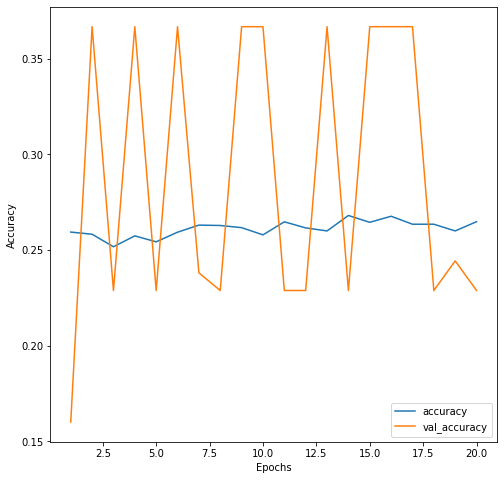

In [ ]:
rn_dict_hist = rn_history.history

#list_ep = [i for i in range(1, len(dict_hist['lr'])+1)]

list_ep = [i for i in range(1, 21)]   #adjust for number of epochs

plt.figure(figsize = (8, 8))

plt.plot(list_ep, rn_dict_hist['accuracy'],  label = 'accuracy') 

plt.plot(list_ep, rn_dict_hist['val_accuracy'],  label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()


In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

In [ ]:
test_pred = resnetmodel.predict(x)
y_test = resnetmodel.predict(test_set)

test_pred = np.argmax(test_pred, axis = -1)
y_test = np.argmax(y_test, axis = -1)

4/4 [==============================] - 2s 44ms/step


In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_set:
  predictions = np.concatenate([predictions,  np.argmax(test_pred)]),
  labels = np.concatenate([labels, np.argmax(y_test)])

print(classification_report(labels, predictions))



In [ ]:
#clearing backend
#keras.backend.clear_session()

In [ ]:
for x, y in test_set:
  predictions = np.concatenate([predictions, test_pred])
  labels = np.concatenate([labels, y_test])
print(classification_report(labels, predictions))

cm = confusion_matrix(labels, predictions)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f',
            xticklabels = ['happy', 'sad', 'neutral', 'surprise'],
            yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations and Insights:** A lot of overfit here. It never does run smoothly.



## **EfficientNet Model**

In [ ]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model
EfficientNet = ap.EfficientNetV2B2(include_top=False,weights="imagenet", input_shape= (48, 48, 3)) #rgb is required for EN

EfficientNet.summary()

35839040/35839040 [==============================] - 0s 0us/step
Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                 

In [ ]:
transfer_layer_EfficientNet = EfficientNet.get_layer('block6e_expand_activation')
EfficientNet.trainable = False

x = Flatten()(transfer_layer_EfficientNet.output)

x = Dense(256, activation = 'relu')(x)

x = Dense(128, activation = 'relu')(x)

x = Dropout(0.3)(x)

x = Dense(64, activation = 'relu')(x)

x = BatchNormalization()(x)

pred = Dense(4, activation='softmax')(x)

Efficientnetmodel = Model(EfficientNet.input, pred)

In [ ]:
Efficientnetmodel.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                                                                                            

### **Compiling and Training the Model**

In [ ]:
Efficientnetmodel.compile(optimizer = Adam(learning_rate = 0.001), 
                 loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
start = time.time()

en_history = Efficientnetmodel.fit(train_set, 
                       validation_data = validation_set,  
                       epochs=20,
                       batch_size = 32, use_multiprocessing = True)

end = time.time()
print(f'{end - start} seconds')

Epoch 1/20
473/473 [==============================] - 34s 57ms/step - loss: 1.4519 - accuracy: 0.2510 - val_loss: 1.4424 - val_accuracy: 0.2443
Epoch 2/20
473/473 [==============================] - 26s 54ms/step - loss: 1.4012 - accuracy: 0.2571 - val_loss: 1.3960 - val_accuracy: 0.2443
Epoch 3/20
473/473 [==============================] - 26s 54ms/step - loss: 1.3968 - accuracy: 0.2592 - val_loss: 1.4223 - val_accuracy: 0.2443
Epoch 4/20
473/473 [==============================] - 25s 53ms/step - loss: 1.3947 - accuracy: 0.2663 - val_loss: 1.3749 - val_accuracy: 0.2289
Epoch 5/20
473/473 [==============================] - 25s 53ms/step - loss: 1.3937 - accuracy: 0.2633 - val_loss: 1.3850 - val_accuracy: 0.2289
Epoch 6/20
473/473 [==============================] - 25s 53ms/step - loss: 1.3915 - accuracy: 0.2606 - val_loss: 1.3833 - val_accuracy: 0.2443
Epoch 7/20
473/473 [==============================] - 26s 54ms/step - loss: 1.3904 - accuracy: 0.2579 - val_loss: 1.3866 - val_accuracy:

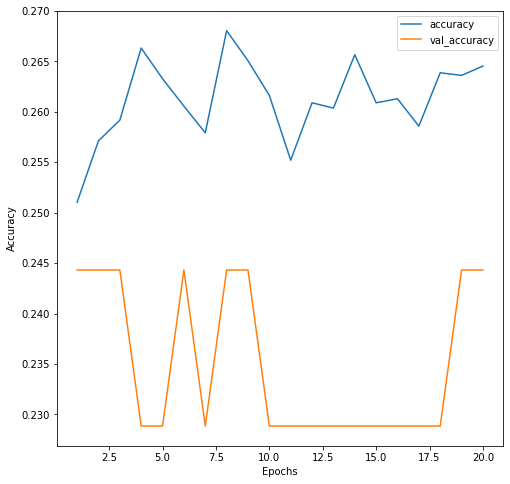

In [ ]:
# Write your code to evaluate the model performance on the test set
en_dict_hist = en_history.history

#list_ep = [i for i in range(1, len(dict_hist['lr'])+1)]

list_ep = [i for i in range(1, 21)]   #adjust for number of epochs

plt.figure(figsize = (8, 8))

plt.plot(list_ep, en_dict_hist['accuracy'],  label = 'accuracy') #ls = '--',

plt.plot(list_ep, en_dict_hist['val_accuracy'], label = 'val_accuracy') #ls = '--', 

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()



In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

### **Evaluating the EfficientnetNet Model**

In [ ]:
predictions = np.array([]) 
labels = np.array([]) 

for x, y in test_set:
  predictions = np.concatenate([predictions, np.argmax(resnetmodel.predict(x),axis=-1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
print(classification_report(labels, predictions))

cm = confusion_matrix(labels, predictions)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f',
            xticklabels = ['happy', 'sad', 'neutral', 'surprise'],
            yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
#clearing backend
#keras.backend.clear_session()

## **Building a Complex Neural Network Architecture**

In [ ]:
no_of_classes = 4

model3 = Sequential()

model3.add(Conv2D(filters = 64, kernel_size = (2,2), padding = "same", activation='relu', input_shape = (48, 48, 1))) 
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 128, kernel_size = (2,2), padding = 'same', activation='relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 512, kernel_size = (2,2), padding = 'same', activation='relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 512, kernel_size = (2,2), padding = 'same', activation='relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 128, kernel_size = (2,2), padding = 'same', activation='relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(0.1))
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Dropout(0.3))                        #some increase in drop out helps

model3.add(Flatten()) #flatten before dense layers

model3.add(Dense(256, activation = 'relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))                        #some increase in drop out helps

model3.add(Dense(512, activation = 'relu'))
model3.add(BatchNormalization())               
model3.add(Dropout(0.5))

model3.add(Dense(4, activation = 'softmax'))


In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        832       
                                                                 
 batch_normalization_14 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 128)      

### **Compiling and Training the Model**

In [ ]:
model3.compile(optimizer = Adam(learning_rate = 4.0163e-04),   #6.7379e-06
                 loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:

def m3_scheduler(epoch, lr):
   if epoch < 10:
     return lr
   #if val_accuracy < accuracy:
    # return lr 
   else:
     return lr * tensorflow.math.exp(-0.1)      # this works for this model, but does not work for the first three models

start = time.time()
callback = keras.callbacks.LearningRateScheduler(m3_scheduler)
m3history = model3.fit(train_set, 
                       validation_data = validation_set,  
                       epochs=35,
                       batch_size = 32, callbacks=[callback], use_multiprocessing = True)

end = time.time()
print(f'{end - start} seconds')

Epoch 1/35
473/473 [==============================] - 18s 35ms/step - loss: 1.9923 - accuracy: 0.2593 - val_loss: 1.3692 - val_accuracy: 0.3026 - lr: 4.0163e-04
Epoch 2/35
473/473 [==============================] - 16s 34ms/step - loss: 1.6656 - accuracy: 0.2620 - val_loss: 1.3784 - val_accuracy: 0.3040 - lr: 4.0163e-04
Epoch 3/35
473/473 [==============================] - 16s 34ms/step - loss: 1.5060 - accuracy: 0.2664 - val_loss: 1.3564 - val_accuracy: 0.3548 - lr: 4.0163e-04
Epoch 4/35
473/473 [==============================] - 16s 34ms/step - loss: 1.4427 - accuracy: 0.2702 - val_loss: 1.3723 - val_accuracy: 0.3215 - lr: 4.0163e-04
Epoch 5/35
473/473 [==============================] - 16s 34ms/step - loss: 1.4081 - accuracy: 0.2760 - val_loss: 1.3895 - val_accuracy: 0.2773 - lr: 4.0163e-04
Epoch 6/35
473/473 [==============================] - 16s 34ms/step - loss: 1.3938 - accuracy: 0.2803 - val_loss: 1.3485 - val_accuracy: 0.3287 - lr: 4.0163e-04
Epoch 7/35
473/473 [==============

### **Evaluating the Model on Test Set**

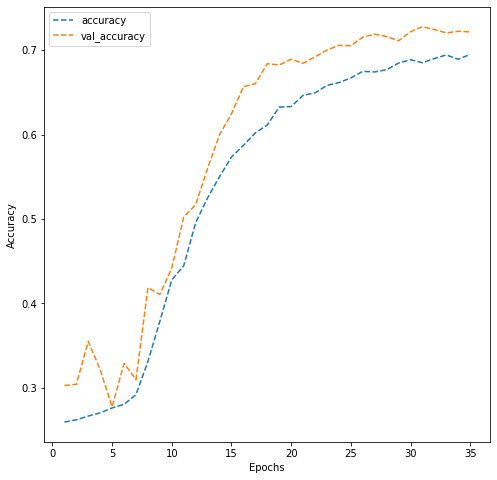

In [ ]:
# Write your code to evaluate the model performance on the test set
m3_dict_hist = m3history.history

#list_ep = [i for i in range(1, len(dict_hist['lr'])+1)]

list_ep = [i for i in range(1, 36)]   #adjust for number of epochs

plt.figure(figsize = (8, 8))

plt.plot(list_ep, m3_dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, m3_dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()



**Observations and Insights:** 
 

*   Using the learning rate callback, I adjust the learning rate of the model based on where the curve of the output is increasing for both accuracy and validation accuracy AND is as close to the same curve as possible.
*   This last run was after clearing backend, because validation rate had dropped off. There is overfitting, but the curve is good.


*   The run above was made using the suggested data gen code.


*   Below is using new data gen code, at the top of the notebook.





 

In [ ]:
#clearing backend
#keras.backend.clear_session()

In [ ]:
#m3history = # Write your code to fit your model. Use train_set as the training data and validation_set as the validation data. Train your model for 35 epochs.

def m3_2_scheduler(epoch, lr):
   if epoch < 10:
     return lr
   #if val_accuracy < accuracy:
    # return lr 
   else:
     return lr * tensorflow.math.exp(-0.1)      # this works for this model, but does not work for the first three models

start = time.time()
callback = keras.callbacks.LearningRateScheduler(m3_2_scheduler)
m3_2history = model3.fit(train_set, 
                       validation_data = validation_set,  
                       epochs=35,
                       batch_size = 32, callbacks=[callback], use_multiprocessing = True)

end = time.time()
print(f'{end - start} seconds')

Epoch 1/35
473/473 [==============================] - 7s 11ms/step - loss: 1.9634 - accuracy: 0.2775 - val_loss: 1.3908 - val_accuracy: 0.3613 - lr: 4.0163e-04
Epoch 2/35
473/473 [==============================] - 5s 11ms/step - loss: 1.6387 - accuracy: 0.2890 - val_loss: 1.3417 - val_accuracy: 0.3637 - lr: 4.0163e-04
Epoch 3/35
473/473 [==============================] - 5s 11ms/step - loss: 1.4685 - accuracy: 0.3050 - val_loss: 1.3215 - val_accuracy: 0.3534 - lr: 4.0163e-04
Epoch 4/35
473/473 [==============================] - 5s 11ms/step - loss: 1.3848 - accuracy: 0.3321 - val_loss: 1.2906 - val_accuracy: 0.3822 - lr: 4.0163e-04
Epoch 5/35
473/473 [==============================] - 5s 11ms/step - loss: 1.2924 - accuracy: 0.3826 - val_loss: 1.2087 - val_accuracy: 0.4567 - lr: 4.0163e-04
Epoch 6/35
473/473 [==============================] - 5s 10ms/step - loss: 1.1913 - accuracy: 0.4513 - val_loss: 1.0943 - val_accuracy: 0.5053 - lr: 4.0163e-04
Epoch 7/35
473/473 [====================

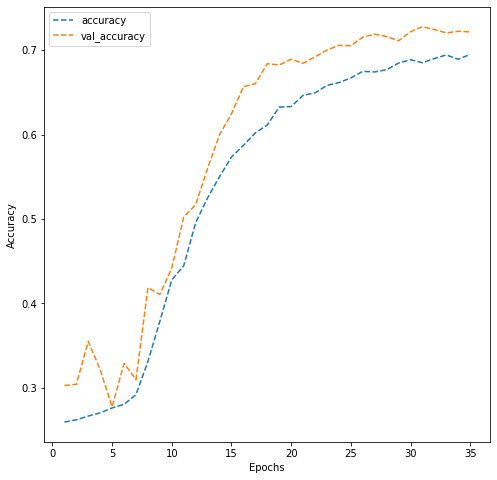

In [ ]:
# Write your code to evaluate the model performance on the test set
m3_2dict_hist = m3_2history.history

#list_ep = [i for i in range(1, len(dict_hist['lr'])+1)]

list_ep = [i for i in range(1, 36)]   #adjust for number of epochs

plt.figure(figsize = (8, 8))

plt.plot(list_ep, m3_dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, m3_dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.legend()

plt.show()



In [ ]:
# Clearing backend

from tensorflow.keras import backend

backend.clear_session()

### **Plotting the Confusion Matrix for the chosen final model**

In [ ]:
#confusion matrix
predictions = np.array([]) 
labels = np.array([]) 

for x, y in test_set:
  predictions = np.concatenate([predictions, np.argmax(model3.predict(x),axis=-1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
print(classification_report(labels, predictions))

cm = confusion_matrix(labels, predictions)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f',
            xticklabels = ['happy', 'sad', 'neutral', 'surprise'],
            yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
#clearing backend
#keras.backend.clear_session()